In [ ]:
# ============================================================
# 🧠 CTD-FusionNet (Colab, auto-path, Albumentations v2 fixed)
# RGB + NOISE (DPR + CTD novelty) + SPSL + Attention Fusion
# Logs metrics to CSV on Drive, shows curves & confusion matrix
# ============================================================

# 1) Install deps
!pip install -q timm scikit-learn opencv-python albumentations tqdm matplotlib pytorch-optimizer seaborn

# 2) Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# 3) Imports
import os, cv2, random, warnings, zipfile
import numpy as np
import timm, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from pytorch_optimizer import Lookahead
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt, seaborn as sns, pandas as pd

# ---------------- Setup ----------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

# ---------------- Unzip from Drive ----------------
zip_path = "/content/drive/MyDrive/Dataset.zip"   # <-- your uploaded zip at Drive root
extract_dir = "/content/Dataset"
if not os.path.exists(extract_dir):
    print("📦 Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
print("✅ Dataset extracted to:", extract_dir)

# ---------------- Auto-detect Train/Test depth ----------------
def find_train_test_dirs(base):
    # Finds the first directory level that contains both Train and Test
    for root, dirs, files in os.walk(base):
        if "Train" in dirs and "Test" in dirs:
            return os.path.join(root, "Train"), os.path.join(root, "Test")
    raise FileNotFoundError(f"❌ Could not find Train/Test under {base}")

TRAIN_DIR, TEST_DIR = find_train_test_dirs(extract_dir)
TRAIN_REAL = os.path.join(TRAIN_DIR, "Real")
TRAIN_FAKE = os.path.join(TRAIN_DIR, "Fake")
TEST_REAL  = os.path.join(TEST_DIR,  "Real")
TEST_FAKE  = os.path.join(TEST_DIR,  "Fake")

for d in [TRAIN_REAL, TRAIN_FAKE, TEST_REAL, TEST_FAKE]:
    if not os.path.exists(d):
        raise FileNotFoundError(f"❌ Missing folder: {d}")
    print(f"{d} → {len(os.listdir(d))} images")

def list_images(folder):
    return sorted([os.path.join(folder, f) for f in os.listdir(folder)
                   if f.lower().endswith(('.jpg','.jpeg','.png','.bmp','.webp'))])

X_train = list_images(TRAIN_REAL) + list_images(TRAIN_FAKE)
y_train = [0]*len(list_images(TRAIN_REAL)) + [1]*len(list_images(TRAIN_FAKE))
X_val   = list_images(TEST_REAL) + list_images(TEST_FAKE)
y_val   = [0]*len(list_images(TEST_REAL)) + [1]*len(list_images(TEST_FAKE))
print(f"Train={len(X_train)}, Val={len(X_val)}")

# ---------------- Dataset & Augmentations ----------------
IMG_SIZE = 380

# Albumentations v2: RandomResizedCrop requires size=(H, W)
train_tfm = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.7, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.GaussNoise(p=0.2),
    A.ColorJitter(0.3, 0.3, 0.3, 0.1, p=0.5),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
], additional_targets={"noise":"image"})

val_tfm = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
], additional_targets={"noise":"image"})

def fast_denoise_rgb(img):
    # DPR-style residual: img - denoise(img)
    return cv2.fastNlMeansDenoisingColored(img, None, 7, 7, 7, 21)

class DeepfakeDataset(Dataset):
    def __init__(self, paths, labels, transform):
        self.paths, self.labels, self.transform = paths, labels, transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        img = cv2.cvtColor(cv2.imread(self.paths[i]), cv2.COLOR_BGR2RGB)
        den = fast_denoise_rgb(img)
        noise = np.clip(img - den + 128, 0, 255).astype(np.uint8)
        t = self.transform(image=img, noise=noise)
        return t["image"], t["noise"], torch.tensor(self.labels[i]).long()

train_ds = DeepfakeDataset(X_train, y_train, train_tfm)
val_ds   = DeepfakeDataset(X_val,   y_val,   val_tfm)
train_loader = DataLoader(train_ds, batch_size=6, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=6, shuffle=False, num_workers=2, pin_memory=True)

# ---------------- Model (RGB + NOISE + SPSL + CTD) ----------------
class AttentionFusion(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.q = nn.Linear(dim, dim)
        self.k = nn.Linear(dim, dim)
        self.v = nn.Linear(dim, dim)
        self.scale = dim ** 0.5
    def forward(self, q_in, k_in):
        attn = torch.softmax((self.q(q_in) @ self.k(k_in).T) / self.scale, dim=-1)
        return q_in + attn @ self.v(k_in)

class NoiseBranchCTD(nn.Module):
    """Noise branch with a learned PRNU (camera-trace) head."""
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model("efficientnet_b3", pretrained=True, features_only=True)
        ch = self.backbone.feature_info[-1]['num_chs']
        self.prnu_head = nn.Sequential(
            nn.Conv2d(ch, 64, 1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, 1)
        )
    def forward(self, noise_img):
        fmap = self.backbone(noise_img)[-1]   # [B,C,h,w]
        prnu = self.prnu_head(fmap)           # [B,1,h,w]  (available if you add aux losses later)
        return fmap, prnu

class FusionNetCTD(nn.Module):
    def __init__(self):
        super().__init__()
        self.rgb_branch   = timm.create_model("convnext_small", pretrained=True, features_only=True)
        self.noise_branch = NoiseBranchCTD()
        self.spsl_branch  = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, num_classes=0)

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.rgb_proj   = nn.Linear(self.rgb_branch.feature_info[-1]['num_chs'], 512)
        self.noise_proj = nn.Linear(self.noise_branch.backbone.feature_info[-1]['num_chs'], 512)
        self.spsl_proj  = nn.Linear(self.spsl_branch.num_features, 512)

        self.attn = AttentionFusion(512)
        self.head = nn.Sequential(
            nn.Linear(512*3, 512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, 128), nn.ReLU(), nn.Linear(128, 2)
        )

    def forward(self, img, noise):
        # RGB
        rgb_map = self.rgb_branch(img)[-1]
        rgb_vec = self.pool(rgb_map).flatten(1)

        # NOISE (CTD)
        fmap, _prnu = self.noise_branch(noise)
        noise_vec = self.pool(fmap).flatten(1)

        # SPSL (Swin on 224x224)
        swin_in = F.interpolate(img, (224, 224), mode='bilinear', align_corners=False)
        spsl_vec = self.spsl_branch(swin_in)

        # Projections
        rgb_vec   = self.rgb_proj(rgb_vec)
        noise_vec = self.noise_proj(noise_vec)
        spsl_vec  = self.spsl_proj(spsl_vec)

        # Cross-modal attention + fusion
        rgb_attn = self.attn(rgb_vec, noise_vec)
        fused = torch.cat([rgb_attn, noise_vec, spsl_vec], dim=1)
        return self.head(fused)

model = FusionNetCTD().to(device)

# ---------------- Training ----------------
criterion = nn.CrossEntropyLoss()
opt = Lookahead(torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4))
EPOCHS = 6
best_auc, hist = 0.0, []

for e in range(1, EPOCHS+1):
    model.train(); tloss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {e}/{EPOCHS}")
    for img, noise, lab in pbar:
        img, noise, lab = img.to(device), noise.to(device), lab.to(device)
        opt.zero_grad(set_to_none=True)
        out = model(img, noise)
        loss = criterion(out, lab)
        loss.backward(); opt.step()
        tloss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.3f}")
    tloss /= max(1, len(train_loader))

    # Validation
    model.eval(); y_true, y_prob = [], []
    with torch.no_grad():
        for img, noise, lab in val_loader:
            img, noise = img.to(device), noise.to(device)
            logits = model(img, noise)
            prob = F.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()
            y_prob.extend(prob); y_true.extend(lab.numpy())
    y_true, y_prob = np.array(y_true), np.array(y_prob)
    auc = roc_auc_score(y_true, y_prob)
    acc = accuracy_score(y_true, (y_prob >= 0.5).astype(int))
    hist.append({"epoch": e, "train_loss": tloss, "val_auc": auc, "val_acc": acc})
    print(f"✅ Epoch {e} | AUC={auc:.4f} ACC={acc:.4f} Loss={tloss:.4f}")

    if auc > best_auc:
        best_auc = auc
        torch.save(model.state_dict(), "/content/best_ctd_fusionnet.pth")
        print("💾 Saved new best model!")

# ---------------- Save logs & Final Eval ----------------
df = pd.DataFrame(hist)
csv_path = "/content/drive/MyDrive/CTD_FusionNet_training_log.csv"
df.to_csv(csv_path, index=False)
print(f"📈 Training log saved at: {csv_path}")

# Final metrics on val (Test) set using best checkpoint
model.load_state_dict(torch.load("/content/best_ctd_fusionnet.pth", map_location=device))
model.eval(); yt, yp = [], []
with torch.no_grad():
    for img, noise, lab in val_loader:
        img, noise = img.to(device), noise.to(device)
        logits = model(img, noise)
        yp.extend(F.softmax(logits, 1)[:, 1].cpu().numpy())
        yt.extend(lab.numpy())
yt, yp = np.array(yt), np.array(yp)
pred = (yp >= 0.5).astype(int)
auc = roc_auc_score(yt, yp)
acc = accuracy_score(yt, pred)
prec = precision_score(yt, pred, zero_division=0)
rec  = recall_score(yt, pred, zero_division=0)
f1   = f1_score(yt, pred, zero_division=0)
print(f"\n📊 FINAL METRICS\nAUC={auc:.4f}  ACC={acc:.4f}  PREC={prec:.4f}  REC={rec:.4f}  F1={f1:.4f}")

# Confusion matrix
cm = confusion_matrix(yt, pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred Real","Pred Fake"],
            yticklabels=["Actual Real","Actual Fake"])
plt.title("CTD-FusionNet Confusion Matrix")
plt.xlabel("Prediction"); plt.ylabel("Actual")
plt.show()

# Curves
plt.figure(figsize=(6,4))
plt.plot(df["epoch"], df["train_loss"], label="Train Loss")
plt.plot(df["epoch"], df["val_auc"], label="Val AUC")
plt.xlabel("Epoch"); plt.legend(); plt.title("Training Progress"); plt.show()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.1/269.1 kB 26.6 MB/s eta 0:00:00
Mounted at /content/drive
✅ Using device: cuda
📦 Extracting dataset...
✅ Dataset extracted to: /content/Dataset
/content/Dataset/Dataset/Train/Real → 77652 images
/content/Dataset/Dataset/Train/Fake → 72828 images
/content/Dataset/Dataset/Test/Real → 19413 images
/content/Dataset/Dataset/Test/Fake → 18207 images
Train=150480, Val=37620


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Epoch 1/6: 100%|██████████| 25080/25080 [4:44:20<00:00,  1.47it/s, loss=0.126]


KeyboardInterrupt: 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Using device: cuda
✅ Dataset extracted to: /content/Dataset
/content/Dataset/Dataset/Train/Real → 77652 files
/content/Dataset/Dataset/Train/Fake → 72828 files
/content/Dataset/Dataset/Test/Real → 19413 files
/content/Dataset/Dataset/Test/Fake → 18207 files
Train=150480, Val=37620


✅ Model initialized (ConvNeXt + EffNet + SwinTiny + CTD)


Epoch 1/3: 100%|██████████| 18810/18810 [46:44<00:00,  6.71it/s, loss=0.421, lr=2.53e-04]

⏱️ Epoch time: 46.7 min | TrainLoss=0.2892


✅ Val — AUC=0.9578 ACC=0.9411
💾 Saved new best model


Epoch 2/3: 100%|██████████| 18810/18810 [46:36<00:00,  6.73it/s, loss=0.339, lr=9.08e-05]


⏱️ Epoch time: 46.6 min | TrainLoss=0.2493
✅ Val — AUC=0.9944 ACC=0.9629
💾 Saved new best model


Epoch 3/3: 100%|██████████| 18810/18810 [46:37<00:00,  6.72it/s, loss=0.185, lr=2.58e-10]


⏱️ Epoch time: 46.6 min | TrainLoss=nan
✅ Val — AUC=0.9833 ACC=0.9635

📊 FINAL METRICS
AUC=0.9944 ACC=0.9629 PREC=0.9695 REC=0.9534 F1=0.9614


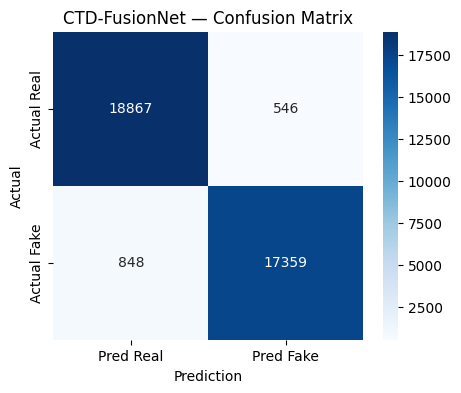

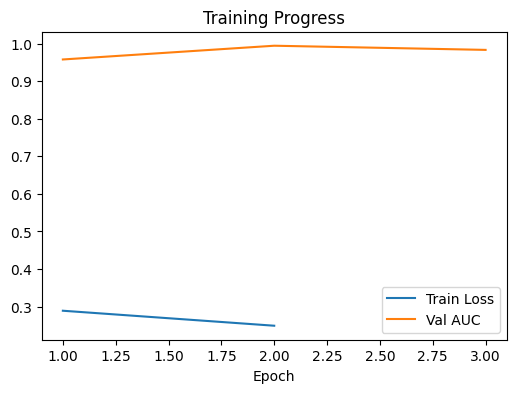

📈 Log saved at: /content/drive/MyDrive/CTD_FusionNet_Stable_log.csv


In [ ]:
# ============================================================
# ⚡ CTD-FusionNet (FAST + STABLE + NaN-safe)
# RGB + NOISE(CTD) + SPSL — ConvNeXt + EffNetB0 + SwinTiny
# ============================================================

!pip install -q timm scikit-learn opencv-python albumentations tqdm matplotlib pytorch-optimizer seaborn

from google.colab import drive
drive.mount('/content/drive')

import os, cv2, random, zipfile, math, time, warnings
import numpy as np
import timm, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from pytorch_optimizer import Lookahead
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt, seaborn as sns, pandas as pd

# ---------------- Setup ----------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

# ---------------- Unzip from Drive ----------------
zip_path = "/content/drive/MyDrive/Dataset.zip"
extract_dir = "/content/Dataset"
if not os.path.exists(extract_dir):
    print("📦 Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
print("✅ Dataset extracted to:", extract_dir)

# ---------------- Auto-detect Train/Test ----------------
def find_train_test_dirs(base):
    for root, dirs, _ in os.walk(base):
        if "Train" in dirs and "Test" in dirs:
            return os.path.join(root, "Train"), os.path.join(root, "Test")
    raise FileNotFoundError("❌ Train/Test folders not found")

TRAIN_DIR, TEST_DIR = find_train_test_dirs(extract_dir)
TRAIN_REAL = os.path.join(TRAIN_DIR, "Real")
TRAIN_FAKE = os.path.join(TRAIN_DIR, "Fake")
TEST_REAL  = os.path.join(TEST_DIR, "Real")
TEST_FAKE  = os.path.join(TEST_DIR, "Fake")

for d in [TRAIN_REAL, TRAIN_FAKE, TEST_REAL, TEST_FAKE]:
    assert os.path.exists(d), f"Missing: {d}"
    print(f"{d} → {len(os.listdir(d))} files")

def list_images(folder):
    return sorted([os.path.join(folder, f) for f in os.listdir(folder)
                   if f.lower().endswith(('.jpg','.jpeg','.png','.bmp','.webp'))])

X_train = list_images(TRAIN_REAL) + list_images(TRAIN_FAKE)
y_train = [0]*len(list_images(TRAIN_REAL)) + [1]*len(list_images(TRAIN_FAKE))
X_val   = list_images(TEST_REAL) + list_images(TEST_FAKE)
y_val   = [0]*len(list_images(TEST_REAL)) + [1]*len(list_images(TEST_FAKE))
print(f"Train={len(X_train)}, Val={len(X_val)}")

# ---------------- Hyperparams ----------------
IMG_SIZE = 224
BATCH_SIZE = 8
NUM_WORKERS = 4
EPOCHS = 3
LABEL_SMOOTH = 0.05

# ---------------- Augmentations ----------------
train_tfm = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.75, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.GaussNoise(p=0.15),
    A.ColorJitter(0.2, 0.2, 0.2, 0.1, p=0.4),
    A.ImageCompression(quality_range=(70, 100), p=0.2),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
], additional_targets={"noise":"image"})

val_tfm = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
], additional_targets={"noise":"image"})

# ---------------- Dataset ----------------
def fast_ctd_residual(img_rgb_uint8):
    den = cv2.GaussianBlur(img_rgb_uint8, (5,5), 0)
    noise = np.clip(img_rgb_uint8 - den + 128, 0, 255).astype(np.uint8)
    return noise

class DeepfakeDataset(Dataset):
    def __init__(self, paths, labels, transform):
        self.paths, self.labels, self.transform = paths, labels, transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        img = cv2.cvtColor(cv2.imread(self.paths[i]), cv2.COLOR_BGR2RGB)
        noise = fast_ctd_residual(img)
        t = self.transform(image=img, noise=noise)
        return t["image"], t["noise"], torch.tensor(self.labels[i]).long()

train_loader = DataLoader(
    DeepfakeDataset(X_train, y_train, train_tfm),
    batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True
)
val_loader = DataLoader(
    DeepfakeDataset(X_val, y_val, val_tfm),
    batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True
)

# ---------------- Model Architecture ----------------
class AttentionFusion(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.q, self.k, self.v = [nn.Linear(dim, dim) for _ in range(3)]
        self.scale = dim ** 0.5
    def forward(self, q_in, k_in):
        attn = torch.softmax((self.q(q_in) @ self.k(k_in).T) / self.scale, dim=-1)
        return q_in + attn @ self.v(k_in)

class NoiseBranchCTD(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model("efficientnet_b0", pretrained=True, features_only=True)
        ch = self.backbone.feature_info[-1]['num_chs']
        self.prnu_head = nn.Sequential(nn.Conv2d(ch, 32, 1), nn.ReLU(True), nn.Conv2d(32, 1, 1))
    def forward(self, noise_img):
        fmap = self.backbone(noise_img)[-1]
        prnu = self.prnu_head(fmap)
        return fmap, prnu

class FusionNetCTD(nn.Module):
    def __init__(self):
        super().__init__()
        self.rgb_branch   = timm.create_model("convnext_tiny", pretrained=True, features_only=True)
        self.noise_branch = NoiseBranchCTD()
        self.spsl_branch  = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, num_classes=0)

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.rgb_proj   = nn.Linear(self.rgb_branch.feature_info[-1]['num_chs'], 384)
        self.noise_proj = nn.Linear(self.noise_branch.backbone.feature_info[-1]['num_chs'], 384)
        self.spsl_proj  = nn.Linear(self.spsl_branch.num_features, 384)

        self.attn = AttentionFusion(384)
        self.head = nn.Sequential(
            nn.Linear(384*3, 384), nn.ReLU(True), nn.Dropout(0.25),
            nn.Linear(384, 96), nn.ReLU(True), nn.Linear(96, 2)
        )

    def forward(self, img, noise):
        rgb_map = self.rgb_branch(img)[-1]
        rgb_vec = self.pool(rgb_map).flatten(1)
        fmap, _ = self.noise_branch(noise)
        noise_vec = self.pool(fmap).flatten(1)
        swin_in = F.interpolate(img, (224,224), mode='bilinear', align_corners=False)
        spsl_vec = self.spsl_branch(swin_in)
        rgb_vec, noise_vec, spsl_vec = self.rgb_proj(rgb_vec), self.noise_proj(noise_vec), self.spsl_proj(spsl_vec)
        rgb_attn = self.attn(rgb_vec, noise_vec)
        fused = torch.cat([rgb_attn, noise_vec, spsl_vec], dim=1)
        return self.head(fused)

model = FusionNetCTD().to(device)
print("✅ Model initialized (ConvNeXt + EffNet + SwinTiny + CTD)")

# ---------------- Loss / Optim ----------------
class LabelSmoothingCE(nn.Module):
    def __init__(self, eps=0.0): super().__init__(); self.eps=eps
    def forward(self, logits, targets):
        n = logits.size(-1)
        logp = F.log_softmax(logits, dim=-1)
        loss = F.nll_loss(logp, targets, reduction='none')
        if self.eps > 0:
            smooth = -logp.mean(dim=-1)
            loss = (1-self.eps)*loss + self.eps*smooth
        return loss.mean()

criterion = LabelSmoothingCE(LABEL_SMOOTH)
base_opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
opt = Lookahead(base_opt)

steps_per_epoch = max(1, len(train_loader))
total_steps = EPOCHS * steps_per_epoch
warmup_steps = int(0.1 * total_steps)
def lr_lambda(step):
    if step < warmup_steps: return step/max(1,warmup_steps)
    progress = (step-warmup_steps)/max(1,total_steps-warmup_steps)
    return 0.5*(1+math.cos(math.pi*progress))
sched = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
scaler = torch.amp.GradScaler("cuda")

# ---------------- Train / Validate ----------------
best_auc, history, global_step = 0.0, [], 0

for epoch in range(1, EPOCHS+1):
    model.train(); tloss=0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
    start_t = time.time()
    for img, noise, lab in pbar:
        img, noise, lab = img.to(device, non_blocking=True), noise.to(device, non_blocking=True), lab.to(device)
        opt.zero_grad(set_to_none=True)
        with torch.amp.autocast("cuda"):
            logits = model(img, noise)
            loss = criterion(logits, lab)
        scaler.scale(loss).backward()
        scaler.step(opt); scaler.update(); sched.step()
        tloss += loss.item(); global_step += 1
        if global_step % 200 == 0:
            pbar.set_postfix(loss=f"{loss.item():.3f}", lr=f"{sched.get_last_lr()[0]:.2e}")
    print(f"⏱️ Epoch time: {(time.time()-start_t)/60:.1f} min | TrainLoss={tloss/len(train_loader):.4f}")

    # -------- Validation (NaN-safe) --------
    model.eval(); y_true, y_prob = [], []
    with torch.no_grad(), torch.amp.autocast("cuda"):
        for img, noise, lab in val_loader:
            img, noise = img.to(device), noise.to(device)
            out = model(img, noise)
            probs = F.softmax(out, dim=1)[:, 1]
            probs = torch.nan_to_num(probs, nan=0.5, posinf=1.0, neginf=0.0).clamp(0.0, 1.0)
            y_prob.extend(probs.cpu().numpy()); y_true.extend(lab.numpy())

    y_true, y_prob = np.array(y_true), np.array(y_prob)
    y_pred = (y_prob >= 0.5).astype(int)
    try:
        auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        auc = float("nan")
        warnings.warn("Validation contained NaN or single class; AUC set to NaN.", RuntimeWarning)

    acc = accuracy_score(y_true, y_pred)
    history.append({"epoch": epoch, "train_loss": tloss/len(train_loader), "val_auc": auc, "val_acc": acc})
    print(f"✅ Val — AUC={auc:.4f} ACC={acc:.4f}")

    if auc > best_auc:
        best_auc = auc
        torch.save(model.state_dict(), "/content/best_ctd_fusionnet_stable.pth")
        print("💾 Saved new best model")

# ---------------- Final Evaluation (NaN-safe) ----------------
model.load_state_dict(torch.load("/content/best_ctd_fusionnet_stable.pth", map_location=device))
model.eval(); yt, yp = [], []
with torch.no_grad(), torch.amp.autocast("cuda"):
    for img, noise, lab in val_loader:
        img, noise = img.to(device), noise.to(device)
        out = model(img, noise)
        probs = F.softmax(out, dim=1)[:, 1]
        probs = torch.nan_to_num(probs, nan=0.5, posinf=1.0, neginf=0.0).clamp(0.0, 1.0)
        yp.extend(probs.cpu().numpy()); yt.extend(lab.numpy())

yt, yp = np.array(yt), np.array(yp); pred = (yp>=0.5).astype(int)
auc = roc_auc_score(yt, yp); acc = accuracy_score(yt, pred)
prec = precision_score(yt, pred, zero_division=0); rec = recall_score(yt, pred, zero_division=0); f1 = f1_score(yt, pred, zero_division=0)
print(f"\n📊 FINAL METRICS\nAUC={auc:.4f} ACC={acc:.4f} PREC={prec:.4f} REC={rec:.4f} F1={f1:.4f}")

cm = confusion_matrix(yt, pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred Real","Pred Fake"],
            yticklabels=["Actual Real","Actual Fake"])
plt.title("CTD-FusionNet — Confusion Matrix"); plt.xlabel("Prediction"); plt.ylabel("Actual")
plt.show()

df = pd.DataFrame(history)
plt.figure(figsize=(6,4))
plt.plot(df["epoch"], df["train_loss"], label="Train Loss")
plt.plot(df["epoch"], df["val_auc"], label="Val AUC")
plt.xlabel("Epoch"); plt.legend(); plt.title("Training Progress"); plt.show()

csv_path = "/content/drive/MyDrive/CTD_FusionNet_Stable_log.csv"
df.to_csv(csv_path, index=False)
print(f"📈 Log saved at: {csv_path}")


In [ ]:
pip install -q timm albumentations opencv-python pytorch-optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.1/269.1 kB 22.4 MB/s eta 0:00:00


In [ ]:
%%writefile InferenceDeepfake.py
# ============================================================
# 🔍 Deepfake Detector — Single Image Inference
# Requires the training weights saved as /content/best_ctd_fusionnet_stable.pth
# ============================================================


import io
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from google.colab import files
from IPython.display import display, HTML

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/content/best_ctd_fusionnet_stable.pth"  # update if you saved elsewhere
IMG_SIZE = 224

def fast_ctd_residual(img_rgb_uint8):
    den = cv2.GaussianBlur(img_rgb_uint8, (5, 5), 0)
    noise = np.clip(img_rgb_uint8 - den + 128, 0, 255).astype(np.uint8)
    return noise

val_tfm = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ],
    additional_targets={"noise": "image"},
)

class AttentionFusion(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.q, self.k, self.v = [nn.Linear(dim, dim) for _ in range(3)]
        self.scale = dim ** 0.5

    def forward(self, q_in, k_in):
        attn = torch.softmax((self.q(q_in) @ self.k(k_in).T) / self.scale, dim=-1)
        return q_in + attn @ self.v(k_in)

class NoiseBranchCTD(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model("efficientnet_b0", pretrained=True, features_only=True)
        ch = self.backbone.feature_info[-1]['num_chs']
        self.prnu_head = nn.Sequential(nn.Conv2d(ch, 32, 1), nn.ReLU(True), nn.Conv2d(32, 1, 1))

    def forward(self, noise_img):
        fmap = self.backbone(noise_img)[-1]
        prnu = self.prnu_head(fmap)
        return fmap, prnu

class FusionNetCTD(nn.Module):
    def __init__(self):
        super().__init__()
        self.rgb_branch   = timm.create_model("convnext_tiny", pretrained=True, features_only=True)
        self.noise_branch = NoiseBranchCTD()
        self.spsl_branch  = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, num_classes=0)

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.rgb_proj   = nn.Linear(self.rgb_branch.feature_info[-1]['num_chs'], 384)
        self.noise_proj = nn.Linear(self.noise_branch.backbone.feature_info[-1]['num_chs'], 384)
        self.spsl_proj  = nn.Linear(self.spsl_branch.num_features, 384)

        self.attn = AttentionFusion(384)
        self.head = nn.Sequential(
            nn.Linear(384 * 3, 384), nn.ReLU(True), nn.Dropout(0.25),
            nn.Linear(384, 96), nn.ReLU(True), nn.Linear(96, 2)
        )

    def forward(self, img, noise):
        rgb_map = self.rgb_branch(img)[-1]
        rgb_vec = self.pool(rgb_map).flatten(1)

        fmap, _ = self.noise_branch(noise)
        noise_vec = self.pool(fmap).flatten(1)

        swin_in = F.interpolate(img, (224, 224), mode='bilinear', align_corners=False)
        spsl_vec = self.spsl_branch(swin_in)

        rgb_vec = self.rgb_proj(rgb_vec)
        noise_vec = self.noise_proj(noise_vec)
        spsl_vec = self.spsl_proj(spsl_vec)

        rgb_attn = self.attn(rgb_vec, noise_vec)
        fused = torch.cat([rgb_attn, noise_vec, spsl_vec], dim=1)
        return self.head(fused)

def load_model():
    model = FusionNetCTD().to(DEVICE)
    state = torch.load(MODEL_PATH, map_location=DEVICE)
    model.load_state_dict(state)
    model.eval()
    return model

MODEL = load_model()

def predict_image(image_bytes):
    arr = np.frombuffer(image_bytes, np.uint8)
    img_bgr = cv2.imdecode(arr, cv2.IMREAD_COLOR)
    if img_bgr is None:
        raise ValueError("Could not decode the uploaded file as an image.")

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    noise = fast_ctd_residual(img_rgb)

    transformed = val_tfm(image=img_rgb, noise=noise)
    img_tensor = transformed["image"].unsqueeze(0).to(DEVICE)
    noise_tensor = transformed["noise"].unsqueeze(0).to(DEVICE)

    with torch.no_grad(), torch.amp.autocast(device_type=DEVICE.type if DEVICE.type != "cpu" else "cpu"):
        logits = MODEL(img_tensor, noise_tensor)
        probs = F.softmax(logits, dim=1)[0]
        probs = torch.nan_to_num(probs, nan=0.5, posinf=1.0, neginf=0.0).clamp(0.0, 1.0)

    prob_fake = float(probs[1].cpu())
    prob_real = float(probs[0].cpu())
    label = "AI-generated (FAKE)" if prob_fake >= 0.5 else "Authentic (REAL)"

    return img_rgb, prob_real, prob_fake, label

def run_detector():
    display(HTML("<h3>🔄 Upload an image to classify</h3>"))
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded.")
        return

    for filename, data in uploaded.items():
        try:
            img_rgb, p_real, p_fake, label = predict_image(data)
            _, encoded_img = cv2.imencode(".jpg", cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
            display(HTML(
                f"<h4>Result for <code>{filename}</code></h4>"
                f"<p><strong>Prediction:</strong> {label}</p>"
                f"<p>Confidence — Real: {p_real:.4f} | Fake: {p_fake:.4f}</p>"
                f"<img src='data:image/jpeg;base64,{encoded_img.tobytes().hex()}' "
                f"style='max-width:400px;border:1px solid #ccc;padding:4px;'>"
            ))
        except Exception as exc:
            print(f"Error processing {filename}: {exc}")

if __name__ == "__main__":
    print(f"✅ Ready — using device: {DEVICE}")
    run_detector()

Overwriting InferenceDeepfake.py


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls -lh /content/drive/MyDrive | grep best_ctd_fusionnet

In [ ]:
!cp /content/drive/MyDrive/best_ctd_fusionnet_stable.pth /content/

cp: cannot stat '/content/drive/MyDrive/best_ctd_fusionnet_stable.pth': No such file or directory


In [ ]:
!python InferenceDeepfake.py

Unexpected keys (bn2.num_batches_tracked, bn2.bias, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.
Traceback (most recent call last):
  File "/content/InferenceDeepfake.py", line 102, in <module>
    MODEL = load_model()
            ^^^^^^^^^^^^
  File "/content/InferenceDeepfake.py", line 97, in load_model
    state = torch.load(MODEL_PATH, map_location=DEVICE)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/serialization.py", line 1484, in load
    with _open_file_like(f, "rb") as opened_file:
         ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/serialization.py", line 759, in _open_file_like
    return _open_file(name_or_buffer, mode)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/serialization.py"